In [1]:
!pip install category_encoders==2.*

     |████████████████████████████████| 80 kB 3.9 MB/s 


In [2]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 86 kB/s 
     |████████████████████████████████| 13.1 MB 23.9 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=ab4d0639bcb1109f2304eacb1127b0850e43b950c08654be77a145b43cf9de94
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [52]:
import io
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, f1_score
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
up = files.upload()

Saving churn.csv to churn.csv


In [65]:
df = pd.read_csv(io.BytesIO(up['churn.csv']),
                 parse_dates=['joining_date'],
                 )

###Exploratory Data Analysis

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Unnamed: 0                    36992 non-null  int64         
 1   age                           36992 non-null  int64         
 2   gender                        36992 non-null  object        
 3   security_no                   36992 non-null  object        
 4   region_category               31564 non-null  object        
 5   membership_category           36992 non-null  object        
 6   joining_date                  36992 non-null  datetime64[ns]
 7   joined_through_referral       36992 non-null  object        
 8   referral_id                   36992 non-null  object        
 9   preferred_offer_types         36704 non-null  object        
 10  medium_of_operation           36992 non-null  object        
 11  internet_option             

In [67]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.describe()

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,0.540982
std,15.867412,228.819900,398.289149,19444.806226,194.063624,0.498324
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,0.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,0.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,1.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,1.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,1.000000


###Visualize the feature distributions

In [68]:
# gather the numeric features
df_nums = df.drop('churn_risk_score', axis=1).select_dtypes(include=[int, float]
                  )
df_nums.columns

Index(['age', 'days_since_last_login', 'avg_time_spent',
       'avg_transaction_value', 'points_in_wallet'],
      dtype='object')

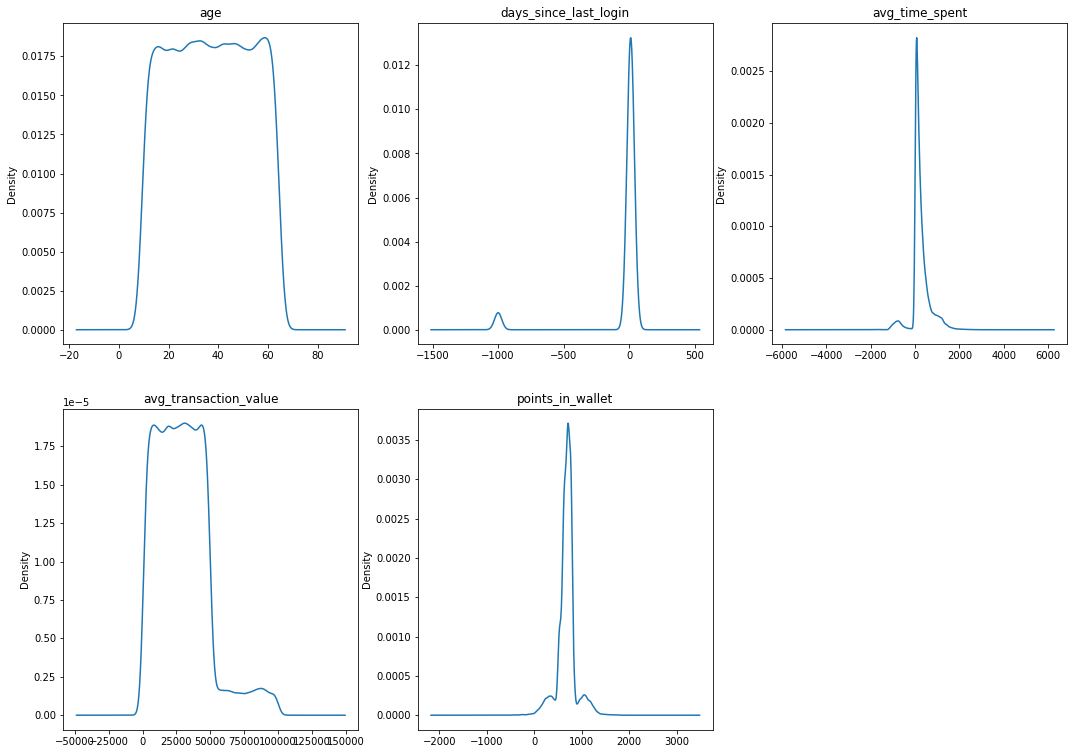

In [69]:
plt.figure(figsize=(18, 13))
for i, col in enumerate(df_nums):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    df_nums[col].plot(kind='kde')

In [70]:
# isolate the categorical variables
df_cats = df.drop(['referral_id','last_visit_time','avg_frequency_login_days',
                      'security_no','joining_date'], axis=1
                     ).select_dtypes(include='object')

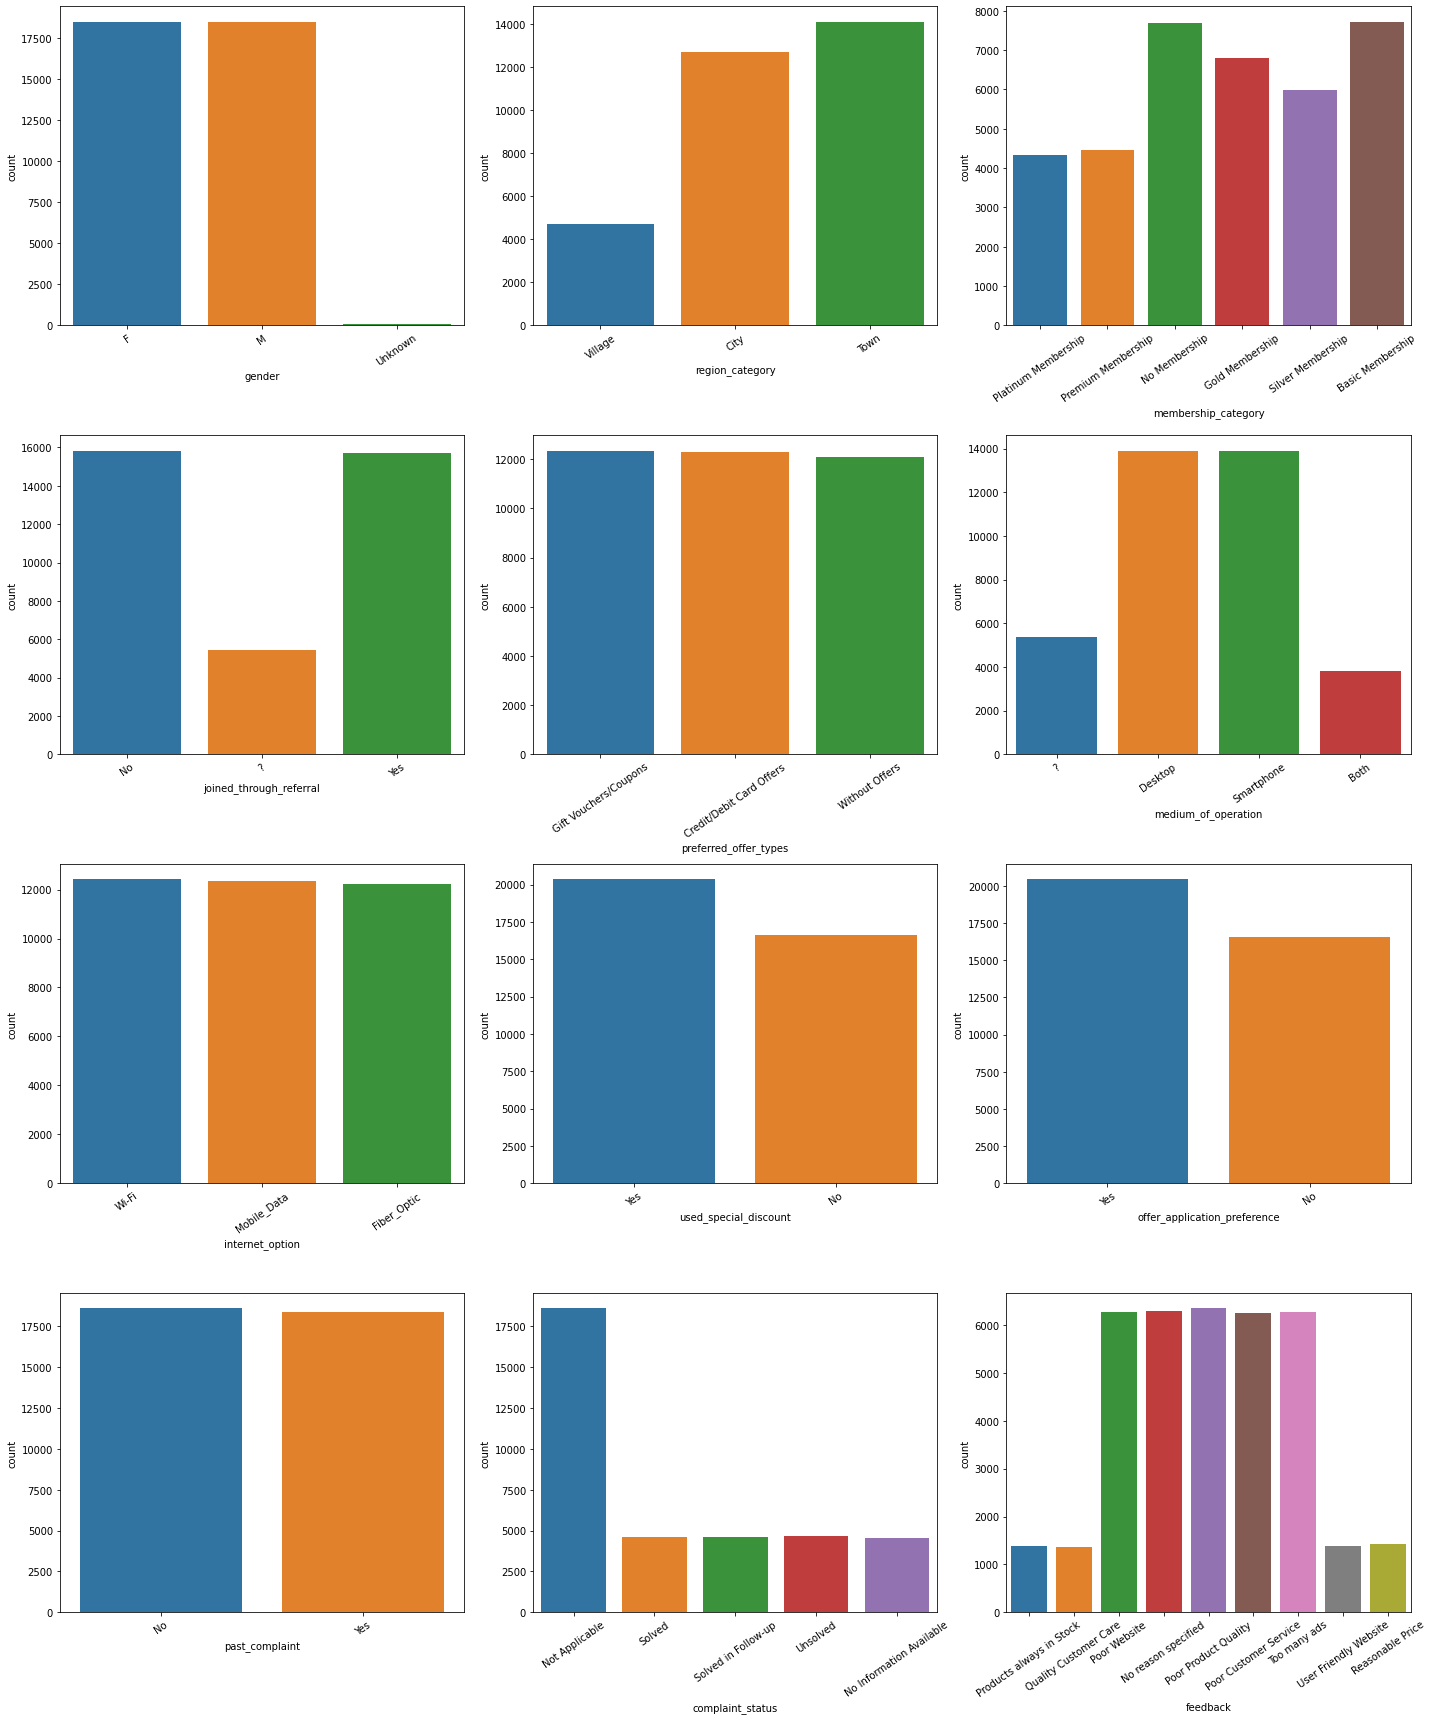

In [71]:
plt.figure(figsize=(20, 24))

for i, col in enumerate(df_cats):
    plt.subplot(4, 3, i+1)
    ax = sns.countplot(x=df_cats[col])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
    plt.tight_layout()
plt.show()

###Target Distribution

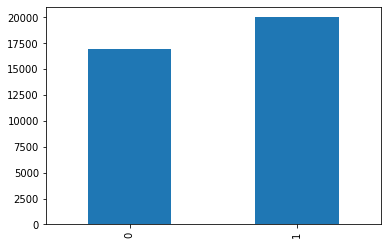

In [72]:
pd.Series([16980, 20012]).plot(kind='bar')
plt.show()

###Data Cleaning and Imputation

In [73]:
# several columns contain invalid values which need to be replaced or removed
df['joined_through_referral'] = pd.Series(
    np.nan if i == '?' else i for i in df['joined_through_referral'])
df['gender'] = df['gender'].replace('Unknown', np.nan)
df['medium_of_operation'] = df['medium_of_operation'].replace('?', np.nan)
df['avg_time_spent'] = df['avg_time_spent'].apply(lambda x: x if x >= 0 else
                                                  np.nan)
df['points_in_wallet'] = df['points_in_wallet'].apply(lambda x: x if x >= 0 else
                                                      np.nan)
df['avg_frequency_login_days'] = df['avg_frequency_login_days'].apply(
    lambda x: x if type(x) == float and x >= 0 else np.nan)
df['days_since_last_login'] = df['days_since_last_login'].apply(
    lambda x: x if x >= 0 else np.nan)

In [74]:
# impute null categorical values with mode of the column
for col in '''joined_through_referral gender medium_of_operation
preferred_offer_types region_category'''.split():
    df[col].fillna(df[col].mode()[0], inplace=True)

In [75]:
missing_num = df[['points_in_wallet', 'avg_time_spent', 'days_since_last_login']
                 ]
imputer = KNNImputer(n_neighbors=3)
imputed_values = imputer.fit_transform(missing_num)

In [76]:
dft = pd.DataFrame({
    x: imputed_values.T[i] for i, x in enumerate(missing_num.columns)
})
df['year'] = df['joining_date'].apply(lambda x: x.year)
cols2drop = '''internet_option joining_date complaint_status region_category
               preferred_offer_types medium_of_operation gender
               joined_through_referral offer_application_preference
               used_special_discount past_complaint'''.split()

df.drop(['avg_frequency_login_days','points_in_wallet','days_since_last_login',
         'avg_time_spent'] + cols2drop, axis = 1, inplace = True)

df = pd.concat([df, dft], axis = 1)

In [77]:
df = df.drop(['security_no', 'referral_id', 'last_visit_time'], axis = 1)

###Split data and establish baseline accuracy

In [78]:
target = 'churn_risk_score'
X = df.drop(columns = [target])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,
                                                    test_size = .19)
baseline = [1] * len(y_test)
print('Baseline accuracy', accuracy_score(y_test, baseline))

Baseline accuracy 0.5436050647318253


###Encode categorical features

In [79]:
cols2encode = []
for x in df:
    if df[x].dtype == 'object':
        if df[x].nunique() <= 10:
            cols2encode += [x]

In [80]:
ord_enc = OrdinalEncoder(cols = cols2encode)

pipe_rf = make_pipeline(ord_enc,
                        StandardScaler(),
                        RandomForestClassifier(random_state = 42, n_jobs = -1))                      

##Grid search model hyperparameters

In [81]:
params_rf = {'randomforestclassifier__max_depth': range(15, 24),
             'randomforestclassifier__max_features': ['auto', 'sqrt'],
             'randomforestclassifier__n_estimators': range(60, 105, 10)}

grid_rf = GridSearchCV(pipe_rf, param_grid = params_rf, n_jobs = -1, cv = 5)
grid_rf.fit(X, y)
grid_rf.best_params_

{'randomforestclassifier__max_depth': 15,
 'randomforestclassifier__max_features': 'auto',
 'randomforestclassifier__n_estimators': 60}

###Construct models with optimized hyperparameters

In [83]:
pipe_rf = make_pipeline(ord_enc,
                        StandardScaler(),
                        RandomForestClassifier(max_depth = 15,
                                               max_features = 'auto',
                                               n_estimators = 60,
                                               random_state = 42, n_jobs = -1))  
pipe_xgb = make_pipeline(ord_enc,
                         StandardScaler(),
                         XGBClassifier(max_depth = 17, n_estimators = 75,
                                       learning_rate = .0000019, n_jobs = -1,
                                       random_state = 42))
pipe_knn = make_pipeline(ord_enc,
                         StandardScaler(),
                         KNeighborsClassifier(n_jobs = -1, n_neighbors = 8,
                                              weights = 'uniform',
                                              algorithm = 'kd_tree',
                                              leaf_size = 35
                                              ))
pipe_logr = make_pipeline(ord_enc,
                          StandardScaler(),
                          LogisticRegression(n_jobs=-1))

In [84]:
m = 'Random_Forest XGB KNeighbors Logistic_Regression'.split()

In [85]:
cv_rf = cross_val_score(pipe_rf, X, y, n_jobs = -1, cv = 5)
cv_xgb = cross_val_score(pipe_xgb, X, y, n_jobs = -1, cv = 5)
cv_knn = cross_val_score(pipe_knn, X, y, n_jobs = -1, cv = 5)
cv_logr = cross_val_score(pipe_logr, X, y, n_jobs = -1, cv = 5)
l = [cv_rf, cv_xgb, cv_knn, cv_logr]
print('\n'.join(f'{b}: cross validation - {a.mean()}' for a, b in zip(l, m)))

Random_Forest: cross validation - 0.9344452997948292
XGB: cross validation - 0.9300389116830085
KNeighbors: cross validation - 0.8797575138292913
Logistic_Regression: cross validation - 0.7376987771631751


In [86]:
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)
pipe_knn.fit(X_train, y_train)
pipe_logr.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['membership_category', 'feedback'],
                                mapping=[{'col': 'membership_category',
                                          'data_type': dtype('O'),
                                          'mapping': No Membership          1
Silver Membership      2
Platinum Membership    3
Basic Membership       4
Premium Membership     5
Gold Membership        6
NaN                   -2
dtype: int64},
                                         {'col': 'feedback',
                                          'data_type': dtype('O'),
                                          'mapping': No reason specified         1
Too many ads                2
Products always in Stock    3
Poor Customer Service       4
Poor Website                5
Poor Product Quality        6
Reasonable Price            7
Quality Customer Care       8
User Friendly Website       9
NaN                        -2
dtype: int64}])),
          

In [87]:
k = {'Training Acc.': [], 'Test Acc.': [], 'F1 Score': []}

In [88]:
for name, model in zip(m, [pipe_rf, pipe_xgb, pipe_knn, pipe_logr]):
    # add the scores to dictionary for later comparison
    k['Training Acc.'] += [model.score(X_train, y_train)]
    k['Test Acc.'] += [model.score(X_test, y_test)]
    k['F1 Score'] += [f1_score(y_test, model.predict(X_test))]
df = pd.DataFrame(k, index = m)

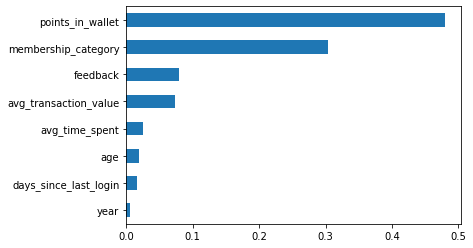

In [90]:
importances = pipe_rf.named_steps['randomforestclassifier'].feature_importances_
feats = X_train.columns
pd.Series(data=importances, index=feats
          ).sort_values().tail(15).plot(kind='barh')
plt.show()

####The feature importances of the models were used in iterating over training cycles in where different features were used to achieve varying accuracy scores

##Confusion Matrices

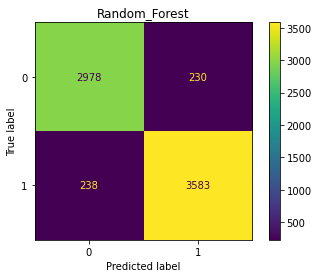

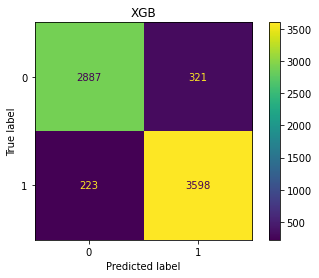

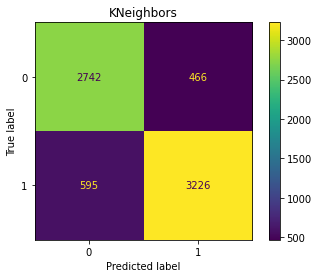

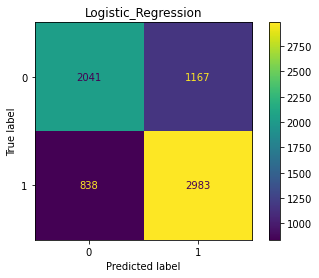

In [91]:
for name, est in zip(m, [pipe_rf, pipe_xgb, pipe_knn, pipe_logr]):
    ConfusionMatrixDisplay.from_estimator(
        est, X_test, y_test)
    plt.title(name)
plt.show()

##Classification Reports - Precision, Recall and F1 Score

In [92]:
for name, est in zip(m, [pipe_rf, pipe_xgb, pipe_knn, pipe_logr]):
    print(name+'\n'+classification_report(y_test, est.predict(X_test)))

Random_Forest
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      3208
           1       0.94      0.94      0.94      3821

    accuracy                           0.93      7029
   macro avg       0.93      0.93      0.93      7029
weighted avg       0.93      0.93      0.93      7029

XGB
              precision    recall  f1-score   support

           0       0.93      0.90      0.91      3208
           1       0.92      0.94      0.93      3821

    accuracy                           0.92      7029
   macro avg       0.92      0.92      0.92      7029
weighted avg       0.92      0.92      0.92      7029

KNeighbors
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      3208
           1       0.87      0.84      0.86      3821

    accuracy                           0.85      7029
   macro avg       0.85      0.85      0.85      7029
weighted avg       0.85      0.85      0.85  

##Next we will look at the partial dependence of predictor variables for the XGBClassifier
- most notable is the dependence of the points_in_wallet feature

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


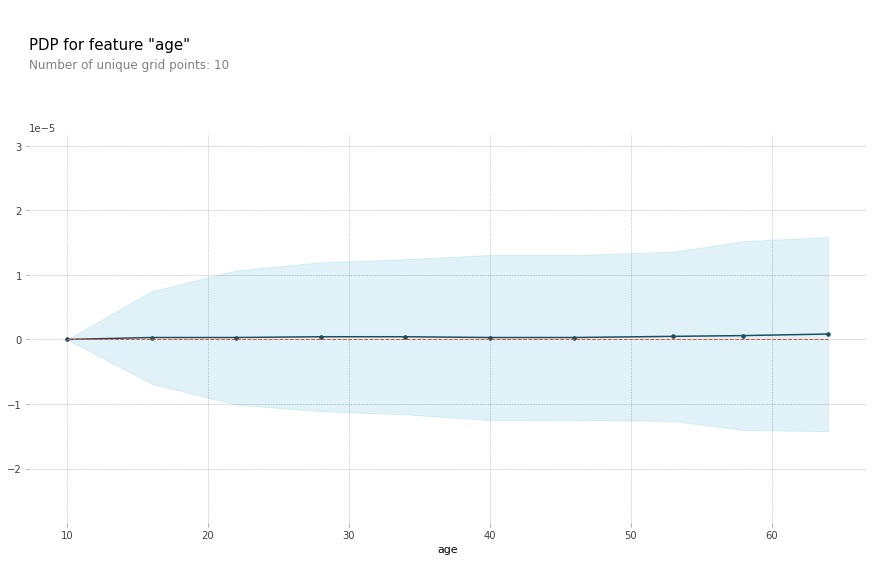

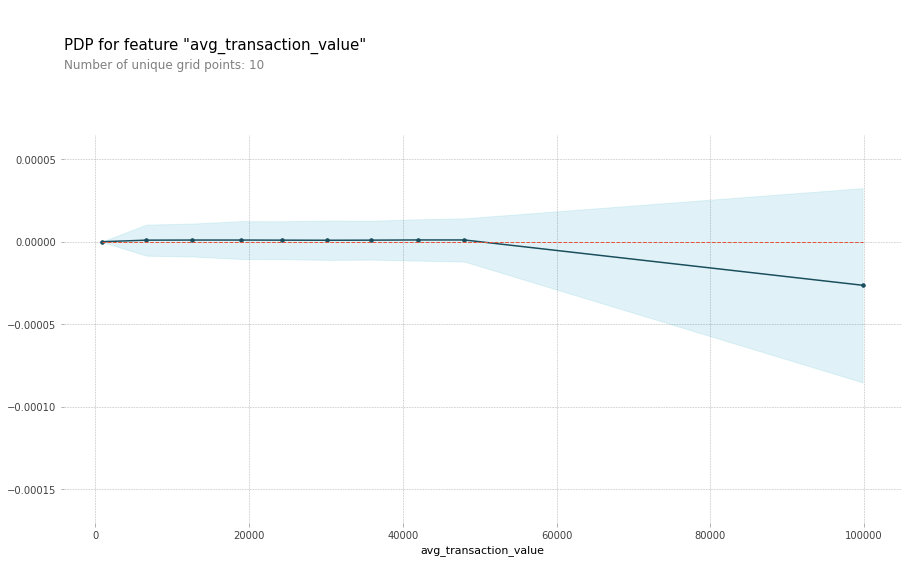

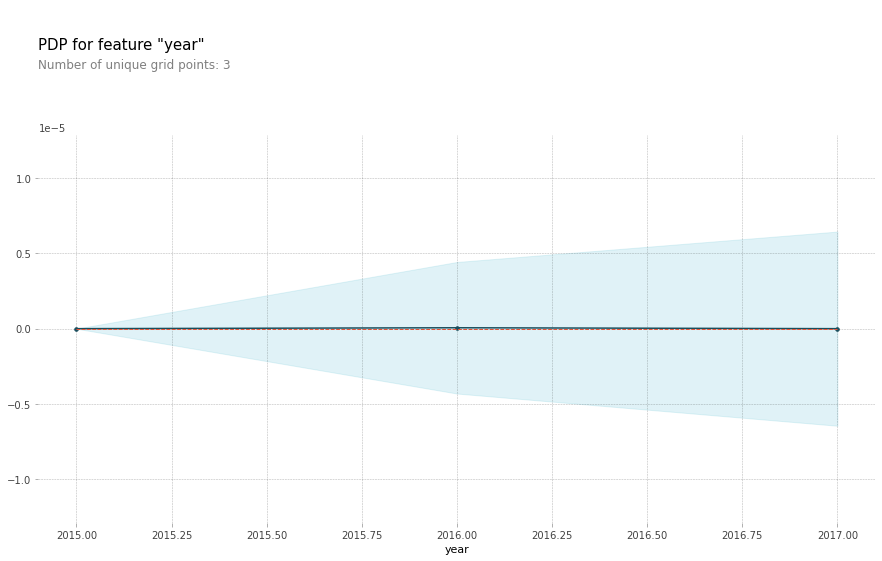

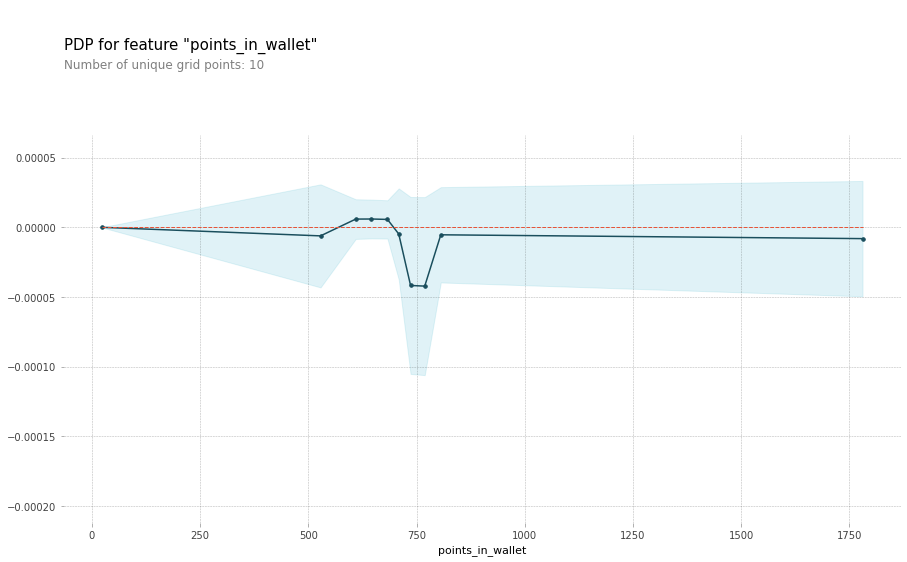

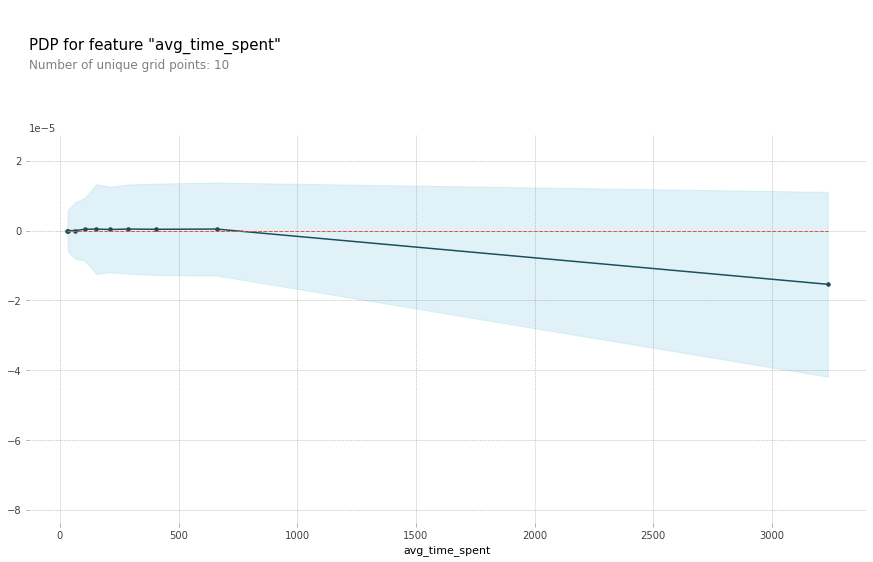

In [93]:
for feat in X_test.drop(columns=['feedback', 'membership_category',
                                 'days_since_last_login']):
    pdp_dist = pdp.pdp_isolate(model = pipe_xgb, dataset = X_test,
                               model_features = X_test.columns, feature = feat)

    pdp.pdp_plot(pdp_dist, feat)
    plt.show()

###As you can see in the PDP plot for points_in_wallet, the predicted value for churn increases right at around 500 points, and decreases right around 700. If you'll recall the Kernal Density Estimate plots shown in the EDA section of this report, points_in_wallet saw a sharp spike in density right around 500 points, and then a decrease at about 700. It is apparent that the majority of customers are within the 500-700 range of points_in_wallet, and it is within reason to say that the majority of customers who churn, come from the majority of customers, and that since the majority customers have a points_in_wallet value in the range of 500-700, a typical points_in_wallet range for a customer to churn with would be 500-700.

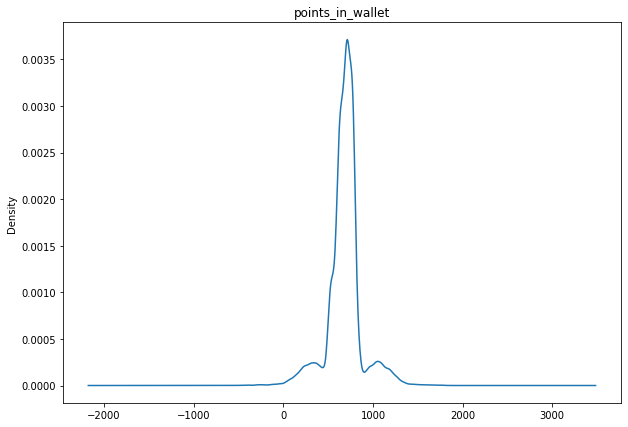

In [94]:
plt.figure(figsize=(10, 7))
col = 'points_in_wallet'
plt.title(col)
df_nums[col].plot(kind='kde')
plt.show()

###Plot the ROC Curve for each classifier

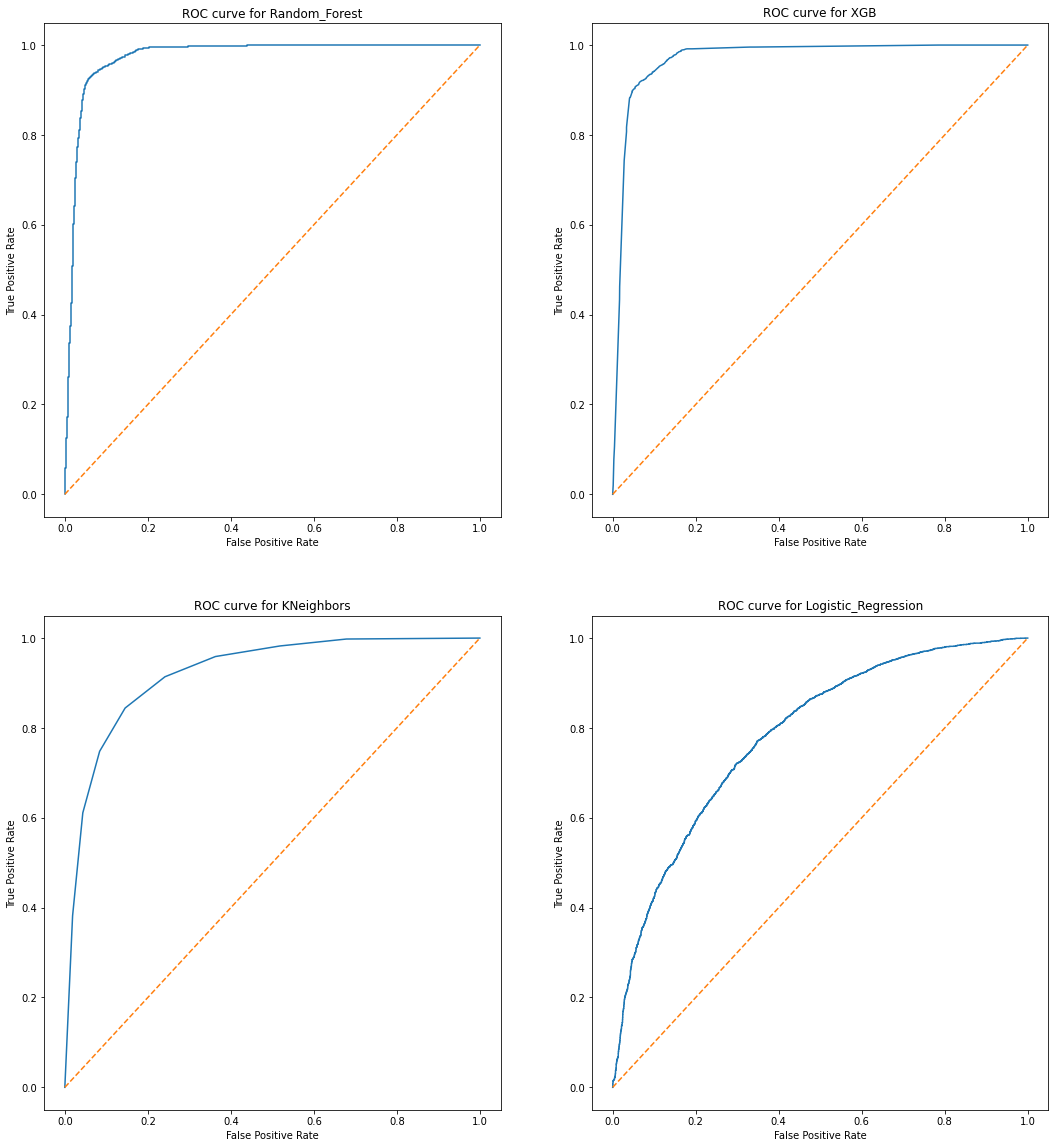

In [95]:
plt.figure(figsize=(18, 20))
for i, est in enumerate(zip(m, [pipe_rf, pipe_xgb, pipe_knn, pipe_logr])):
    y_pred_prob = est[1].predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.subplot(2, 2, i+1)
    plt.plot(fpr, tpr)
    plt.plot([0,1], ls='--')
    plt.title(f'ROC curve for {est[0]}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

###Compare model scores

In [96]:
df.head()

,Training Acc.,Test Acc.,F1 Score
Random_Forest,0.966158,0.933419,0.938695
XGB,0.957648,0.922606,0.929716
KNeighbors,0.882856,0.849054,0.858778
Logistic_Regression,0.703801,0.714753,0.748463
